# Using raster analysis

Raster Analysis can be used to create and execute spatial analysis models and image processing chains which leverage distributed storage and analysis. This powerful capability is available with ArcGIS Enterprise at the 10.5 release, and enables scalable raster analysis including terrain analysis, suitability analysis, vegetation analysis as well as persistent imagery product generation.

The `arcgis.raster.analytics` module provides the raster analysis functionality. This module contains functions that enable you to call raster analysis tools in your GIS.

## About the raster analysis tools

There are many tools available to perform raster analysis:

* **Calculate Density** creates a density layer from point features by spreading known quantities of some phenomenon (represented as attributes of the points) across the raster. The result is a layer of areas classified from least dense to most dense.
* **Classify** categorizes your raster layer into logical categories.
* **Convert Feature To Raster** is used to convert a vector feature class into a raster layer.
* **Convert Raster To Feature** is used to convert a raster layer into a feature class.
* **Copy Raster** is used to create a copy of a raster layer. The new raster layer can be clipped, resampled, or reprojected.
* **Create Viewshed** determines the raster surface locations visible to a set of observer features.
* **Generate Raster** can employ any of the raster functions as raster analytic tools. You can use these to create processed raster datasets from functions and function chains.
* **Interpolate Points** is used to convert irregularly gridded point datasets or multidimensional datasets into raster surfaces.
* **Summarize Raster Within** summarizes a raster based on areas (zones) you define with another layer.
* **Segment** identifies features or segments in your imagery by grouping adjacent pixels together that have similar spectral characteristics.
* **Train Classifier** sets up your classification based on your classification algorithm and parameters.

To invoke these tools, invoke the corresponding function in the [`arcgis.raster.analytics`](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.analytics.html) module.

## Verifying if GIS supports raster analysis

Raster Analysis is available at 10.5 release of ArcGIS Enterprise, and needs to be configured and enabled in the GIS. ArcGIS Online does not yet support raster analysis (as of December 2016). To verify if your GIS has raster analysis capability, use the `arcgis.raster.analytics.is_supported(gis)` method. This function returns True if the GIS supports raster analysis. If a gis isn’t specified, it checks if arcgis.env.active_gis supports raster analysis:

In [ ]:
import arcgis
from arcgis.gis import GIS
from IPython.display import display

arcgis_online = GIS()

In [ ]:
arcgis.raster.analytics.is_supported(arcgis_online)

False

In [ ]:
portal = GIS("portal url", "username","password")

In [ ]:
arcgis.raster.analytics.is_supported(portal)

True

## Creating persistent imagery product using raster analysis

This part of the notebook shows how Raster Analysis (in ArcGIS Enterprise 10.5) can be used to generate a raster information product, by applying the same raster function across the extent of an image service on the portal. The raster function is applied at source resolution and creates an information product, that can be used for analysis and visualization.

An imagery layer containing landsat scenes covering the burned areas from the Montana fires is used as an input for producing the imagery product:

<Item title:"ImgSrv_Landast_Montana2015" type:Image Service owner:admin>
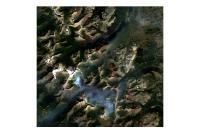

In [ ]:
montana_landsat = portal.content.search("ImgSrv_Landast_Montana2015")[0]
montana_landsat

We can use the `arcgis.raster.analytics.generate_raster()` tool to apply a raster function across the entire extent of the input image layer at source resolution, and persist the result in another output imagery layer. This creates a raster product that can be used for analysis and visualization.

The raster function to be applied is composed as a python dictionary, and extracts the specified bands from the raster datasets:

In [ ]:
# A raster function is created as a python dictionary as shown below:
def extract_bands(bands):
    return {
               "rasterFunction": "Stretch",
               "rasterFunctionArguments":{
                    "Raster":{
                        "rasterFunction": "ExtractBand",
                        "rasterFunctionArguments":{"BandIds": bands}
                    },
                    "StretchType": 6,
                    "DRA": True,
                    "Gamma": [1,1,1],
                    "UseGamma": True
                },
               "outputPixelType":"U8"
            }

### Using `generate_raster()` to create imagery product

In the code below, we use the `arcgis.raster.analytics.generate_raster()` tool to apply the `extact_bands` raster function above to extract the [7, 5, 2] band combination. This improves visibility of fire and burn scars by pushing further into the SWIR range of the electromagnetic spectrum, as there is less susceptibility to smoke and haze generated by a burning fire.

In [ ]:
from arcgis.raster.analytics import generate_raster

montana_fires = generate_raster(extract_bands([7, 5, 2]), montana_landsat)

Submitted.
Executing...
Executing (GenerateRaster): GenerateRaster {"rasterFunction":"Stretch","outputPixelType":"U8","rasterFunctionArguments":{"UseGamma":true,"DRA":true,"Gamma":[1,1,1],"Raster":{"rasterFunction":"ExtractBand","rasterFunctionArguments":{"BandIds":[7,5,2]}},"StretchType":6}} {"serviceProperties":{"name":"GeneratedRasterProduct_VG2XPC","serviceUrl":"http://dev003248.esri.com/rax/rest/services/Hosted/GeneratedRasterProduct_VG2XPC/ImageServer"},"itemProperties":{"itemId":"5a8e3b42181f416591626748de782f42"}} {"Raster":{"itemId":"8c921ea4373c4238b77d526abe3838f5"}} # #
Start Time: Thu Dec 15 12:35:45 2016
Running script GenerateRaster...
Image service GeneratedRasterProduct_VG2XPC already existed.
GetPrivateUrl returns: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/GeneratedRasterProduct_VG2XPC/ImageServer
The service got from item ID is: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/GeneratedRasterProduct_VG2XPC/ImageServer
Output item id is: 5

In [ ]:
montana_fires

<Item title:"GeneratedRasterProduct_VG2XPC" type:Image Service owner:admin>

### Visualizing the generated imagery product

We can compare the natural color and false color images using a tabbed widget.
In the false color image the red and brownish pixels correspond to burn scars of the fire:

In [ ]:
montana_fires = portal.content.search("GeneratedRasterProduct_VG2XPC", "Image Service")[0]
montana_fires

<Item title:"GeneratedRasterProduct_VG2XPC" type:Image Service owner:admin>

In [ ]:
location = arcgis.geocoding.geocode("Marthas Basin, Montana")[0]

base_map = portal.map(location, 12)

natural_color_map = portal.map(location, 12)
natural_color_map.add_layer(montana_landsat)

false_color_map = portal.map(location, 12)
false_color_map.add_layer(montana_fires)

In [ ]:
import ipywidgets as widgets

tab = widgets.Tab([base_map, natural_color_map, false_color_map])
tab.set_title(0, 'Basemap')
tab.set_title(1, 'Natural Color')
tab.set_title(2, 'False Color')
tab

![raster tabbed](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_raster_analysis_01.gif)

## Vegetation analysis

The `generate_raster()` tool can be used for vegetation analysis as well, by passing in the appropriate raster function. Here is a helpful resource for some [well-known raster functions](http://resources.arcgis.com/en/help/rest/apiref/index.html?israsterfunctions.html)

The example below creates an information product that uses NDVI. The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, typically but not necessarily from a space platform, and assess whether the target being observed contains live green vegetation or not.

In [ ]:
ndvi_raster_fn = {"rasterFunction": "BandArithmetic", 
                  "rasterFunctionArguments": {"Method": 1, "BandIndexes": "1 2"}}

montana_ndvi = generate_raster(ndvi_raster_fn, montana_landsat)

Submitted.
Executing...
Executing (GenerateRaster): GenerateRaster {"rasterFunction":"BandArithmetic","rasterFunctionArguments":{"BandIndexes":"1 2","Method":1}} {"serviceProperties":{"name":"GeneratedRasterProduct_JRA9W9","serviceUrl":"http://dev003248.esri.com/rax/rest/services/Hosted/GeneratedRasterProduct_JRA9W9/ImageServer"},"itemProperties":{"itemId":"ac45c8c4ae584defbe76f82f302ccbde"}} {"Raster":{"itemId":"8c921ea4373c4238b77d526abe3838f5"}} # #
Start Time: Thu Dec 15 12:47:54 2016
Running script GenerateRaster...
Image service GeneratedRasterProduct_JRA9W9 already existed.
GetPrivateUrl returns: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/GeneratedRasterProduct_JRA9W9/ImageServer
The service got from item ID is: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/GeneratedRasterProduct_JRA9W9/ImageServer
Output item id is: ac45c8c4ae584defbe76f82f302ccbde
Output image service url is: https://dev003248.esri.com:6443/arcgis/rest/services/Hosted/GeneratedRa

In [ ]:
montana_ndvi = portal.content.search("GeneratedRasterProduct_JRA9W9")[0]

In [ ]:
montana_ndvi

<Item title:"GeneratedRasterProduct_JRA9W9" type:Image Service owner:admin>

In [ ]:
ndvi_map = portal.map(location, 12)
ndvi_map

![montana ndvi](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_raster_analysis_02.png)

In [ ]:
ndvi_map.add_layer(montana_ndvi)